In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import mf2w

In [2]:
tavg_1hr_ctm = xr.open_mfdataset(["data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0030.V01.nc4",
                                  "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0130.V01.nc4",
                                  "data/GEOS.fp.asm.tavg_1hr_ctm_c0720_v72.20210401_0230.V01.nc4"], data_vars=['MFXC', 'MFYC', 'DELP'], compat='override', coords=['time'])
tavg_1hr_ctm = tavg_1hr_ctm.drop(['cubed_sphere', 'contacts', 'orientation', 'anchor', 'TAITIME', 'PS'])
tavg_1hr_ctm = tavg_1hr_ctm.mean(dim=['time'])
tavg3_3d_asm = xr.open_dataset("data/GEOS.fp.asm.tavg3_3d_asm_Nv.20210401_0130.V01.nc4")
c720_grid = xr.open_mfdataset([f"data/c720.tile{n}.nc" for n in range(1,7)], concat_dim='nf', combine='nested')

In [11]:
nf=4
uc, vc = mf2w.mass_fluxes_to_winds(tavg_1hr_ctm.isel(nf=nf), c720_grid.isel(nf=nf))
ua, va = mf2w.cgrid_to_agrid(uc, vc)

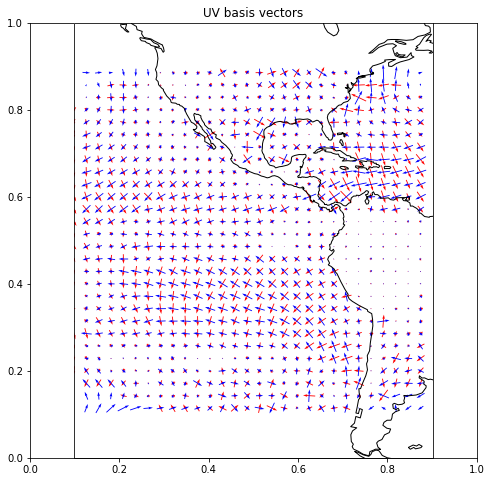

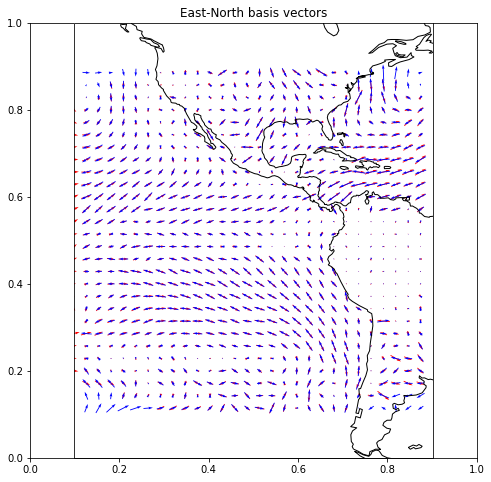

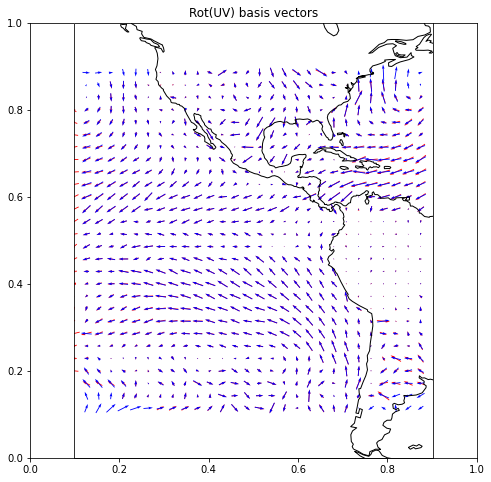

In [13]:
# derived winds (red)
x0 = c720_grid.isel(nf=nf, yc=slice(1, None, 2), xc=slice(1, None, 2)).lons.squeeze().values
x0[x0 > 180] -= 360
y0 = c720_grid.isel(nf=nf, yc=slice(1, None, 2), xc=slice(1, None, 2)).lats.squeeze().values
u0 = ua[-1, :, :]
v0 = va[-1, :, :]

# todo: pad and do matrix multiplication
G2 = mf2w.spherical_to_gmao(np.deg2rad(x0), np.deg2rad(y0), gmao_face=nf+1)
G2 = np.linalg.inv(G)
G3 = mf2w.uv_face_rotations(nf+1)
G3 = np.broadcast_to(G, (*u0.shape, 2, 2))
uv = np.concatenate((u0[..., np.newaxis], v0[..., np.newaxis]), axis=-1)
uv = np.einsum('xyij,xyj->xyi', G2, uv)
u2 = uv[..., 0]
v2 = uv[..., 1]
uv = np.concatenate((u0[..., np.newaxis], v0[..., np.newaxis]), axis=-1)
uv = np.einsum('xyij,xyj->xyi', G3, uv)
u3 = uv[..., 0]
v3 = uv[..., 1]

# diagnostic winds (blue)
x_extent = (x0.min(), x0.max())
y_extent = (y0.min(), y0.max())
x1 = tavg3_3d_asm.lon.sel(lon=slice(*x_extent)).squeeze().values
x1[x1 > 180] -= 360
y1 = tavg3_3d_asm.lat.sel(lat=slice(*y_extent)).squeeze().values
u1 = tavg3_3d_asm.U.isel(time=0,lev=-1).sel(lat=slice(*y_extent),lon=slice(*x_extent)).squeeze().values
v1 = tavg3_3d_asm.V.isel(time=0,lev=-1).sel(lat=slice(*y_extent),lon=slice(*x_extent)).squeeze().values

plt.figure(figsize=(8, 8))
plt.title("UV basis vectors")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent((*x_extent, *y_extent))
plt.quiver(x0, y0, u0, v0, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='red')
plt.quiver(x1, y1, u1, v1, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='blue')

plt.figure(figsize=(8, 8))
plt.title("East-North basis vectors")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent((*x_extent, *y_extent))
plt.quiver(x0, y0, u2, v2, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='red')
plt.quiver(x1, y1, u1, v1, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='blue')

plt.figure(figsize=(8, 8))
plt.title("Rot(UV) basis vectors")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent((*x_extent, *y_extent))
plt.quiver(x0, y0, u3, v3, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='red')
plt.quiver(x1, y1, u1, v1, transform=ccrs.PlateCarree(), regrid_shape=30, scale=300, pivot='mid', color='blue')


In [13]:
nf = 5
mfxc, delpx = mf2w.get_full_mfxc_delpx(tavg_1hr_ctm, nf)
mfyc, delpy = mf2w.get_full_mfyc_delpy(tavg_1hr_ctm, nf)

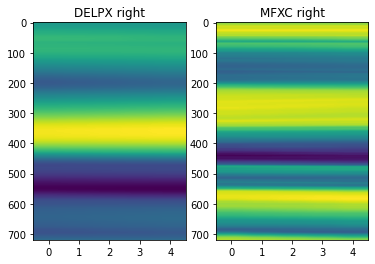

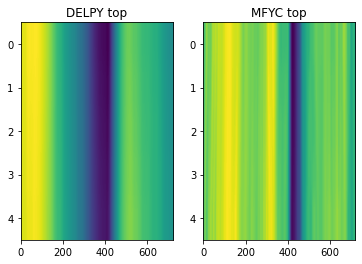

In [14]:
plt.figure()
plt.subplot(1,2,1)
plt.title('DELPX right')
plt.imshow(delpx[-1,...][...,-5:], aspect='auto')
plt.subplot(1,2,2)
plt.title('MFXC right')
plt.imshow(mfxc[-1,...][...,-5:], aspect='auto')

plt.figure()
plt.subplot(1,2,1)
plt.title('DELPY top')
plt.imshow(delpy[-1,...][...,-5:,:], aspect='auto')
plt.subplot(1,2,2)
plt.title('MFYC top')
plt.imshow(mfyc[-1,...][...,-5:,:], aspect='auto')